Dataset shape: (2149, 33)


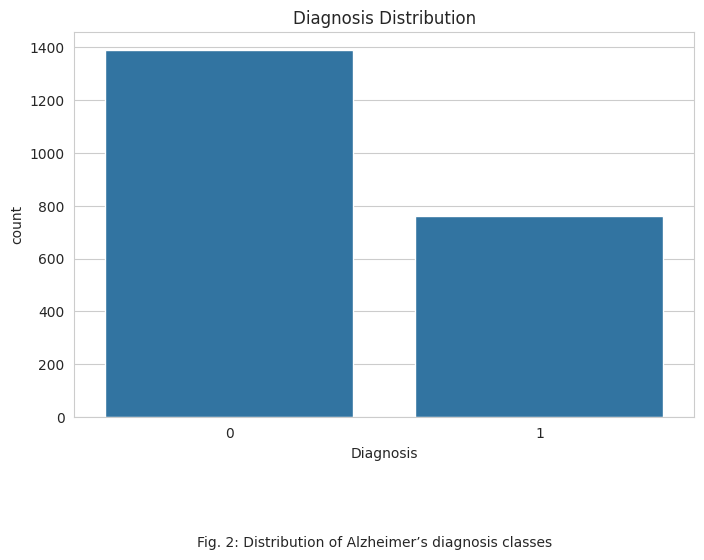

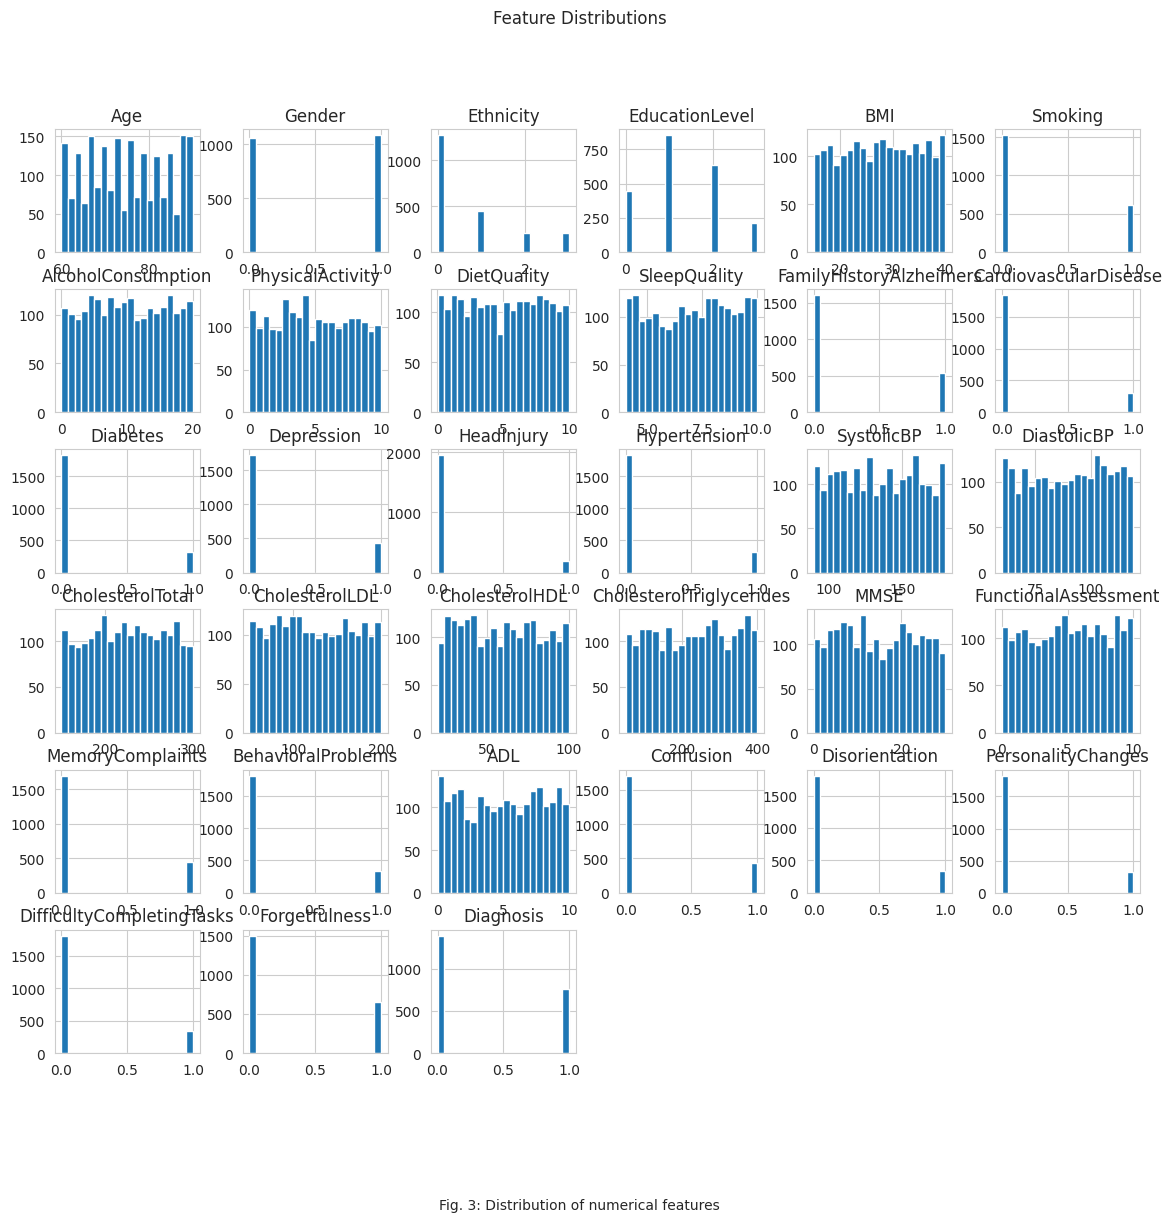

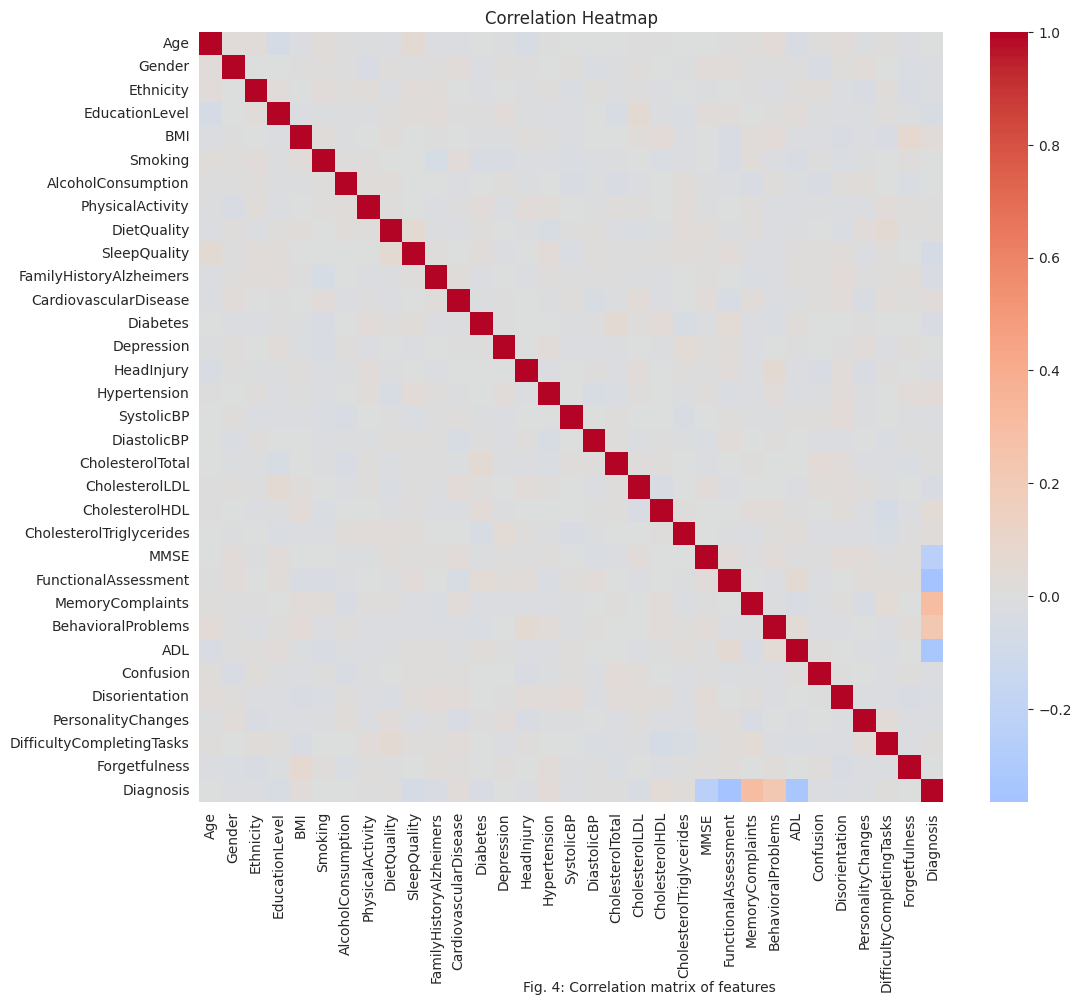

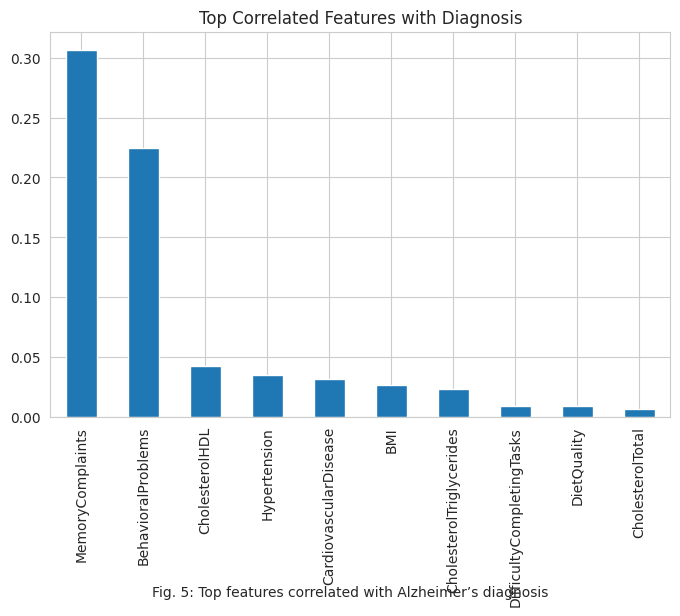

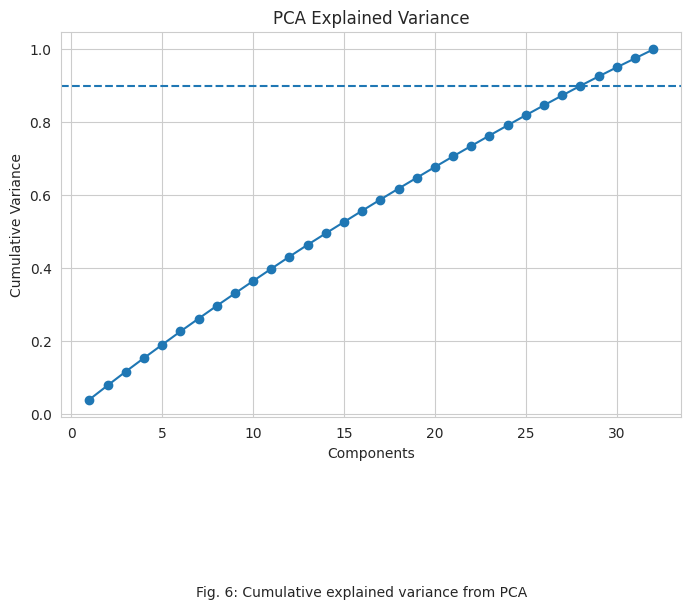

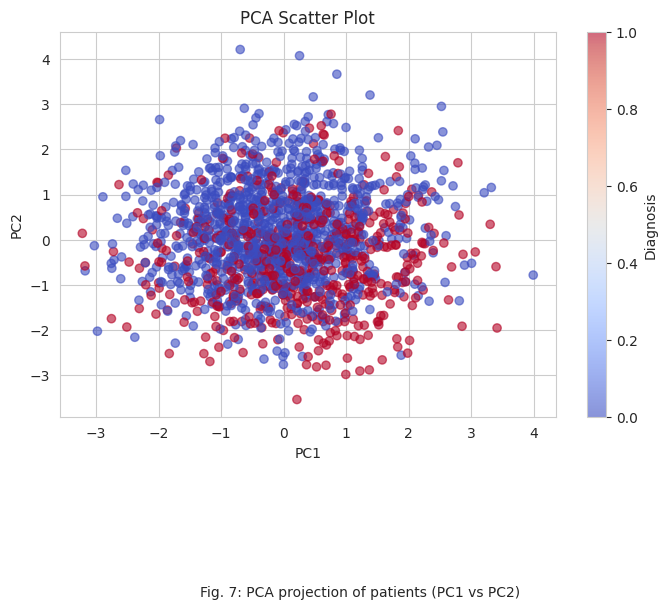

Accuracy: 0.9460966542750929
ROC AUC: 0.9436176648517847
              precision    recall  f1-score   support

           0       0.94      0.97      0.96       348
           1       0.95      0.89      0.92       190

    accuracy                           0.95       538
   macro avg       0.95      0.93      0.94       538
weighted avg       0.95      0.95      0.95       538



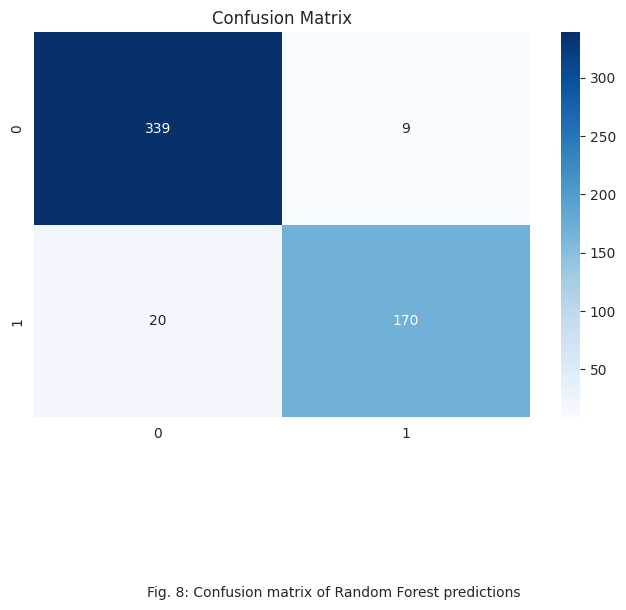

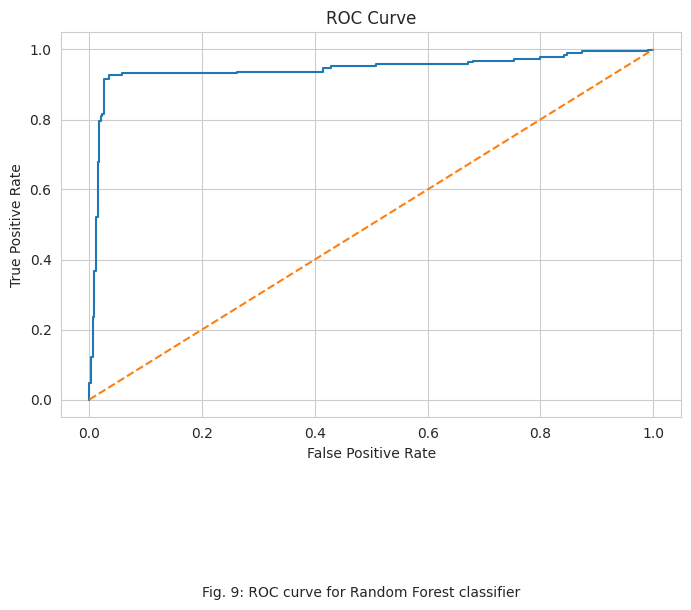

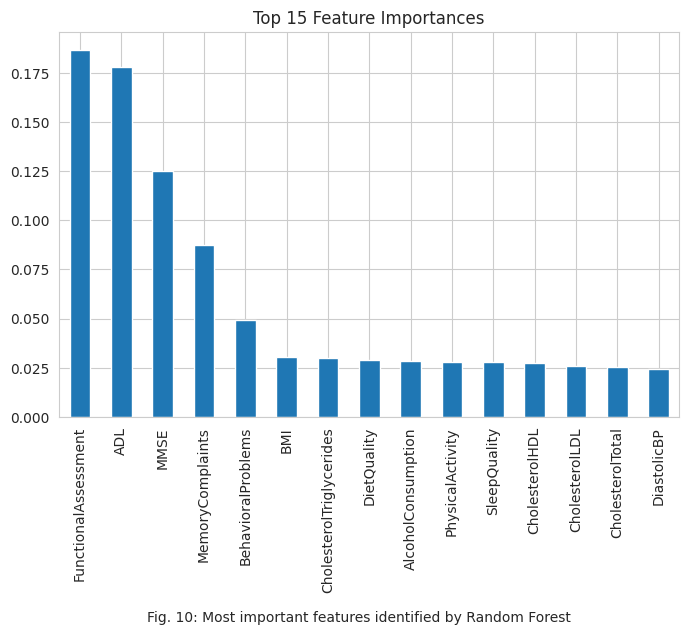

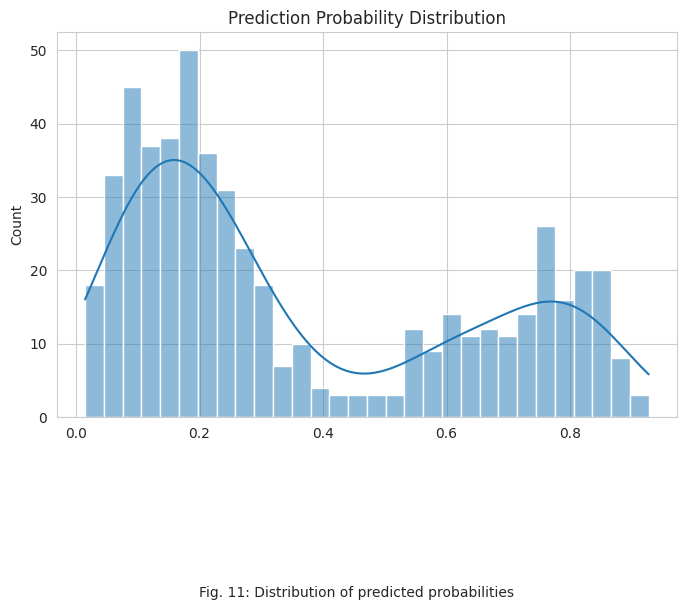

CV Mean: 0.9380506315390036
CV Std: 0.06465290095579074


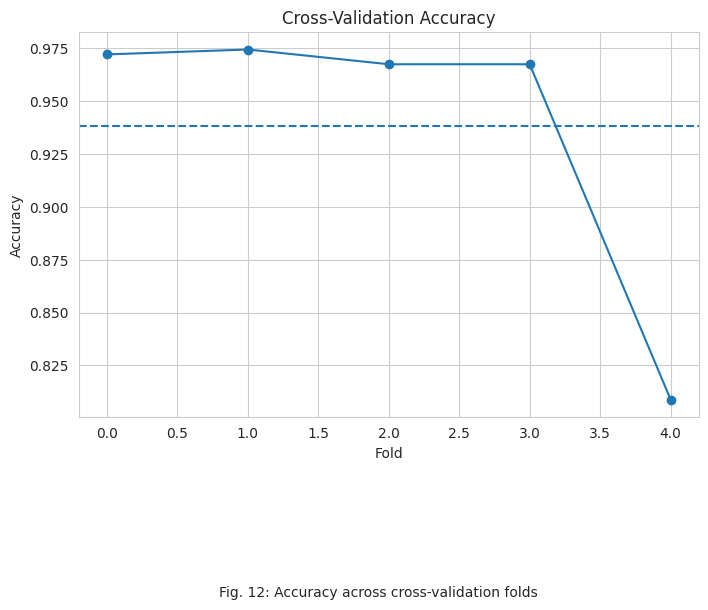

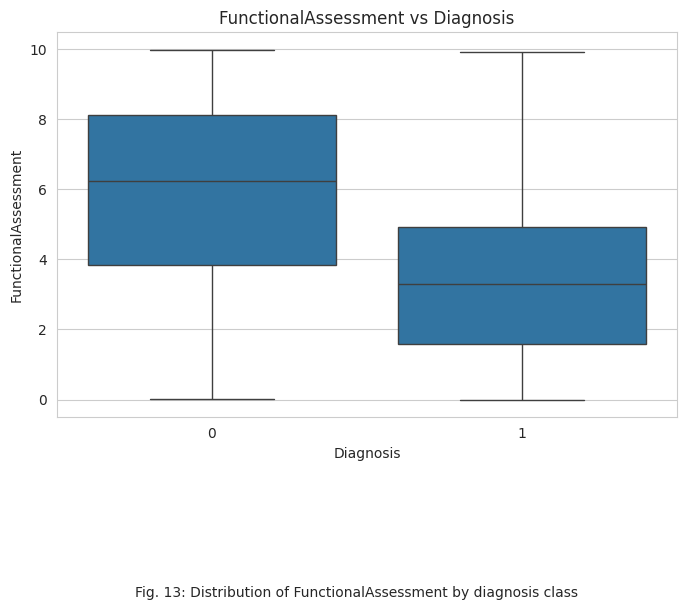

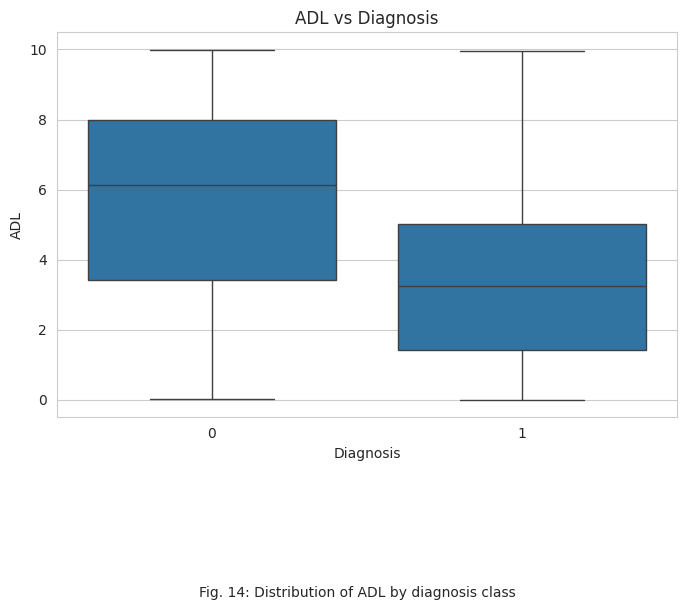

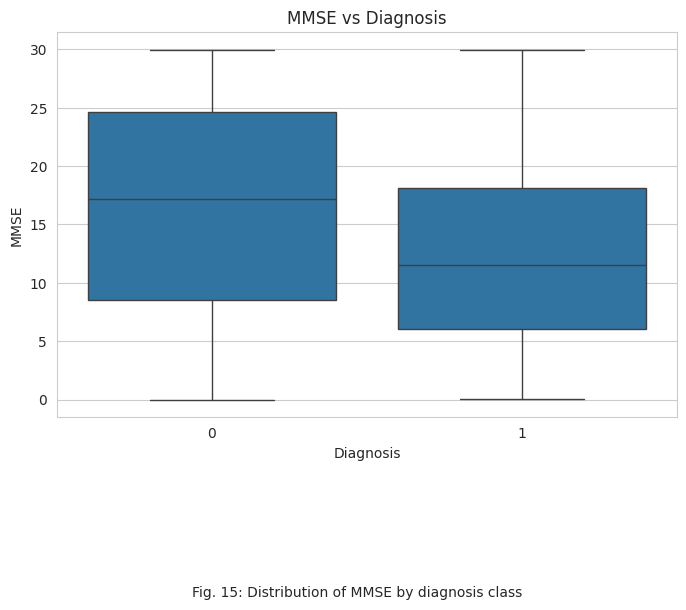

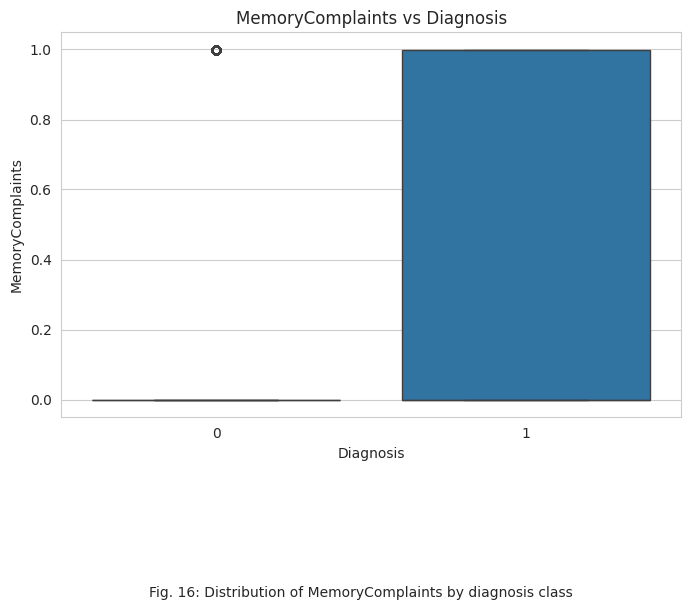

In [ ]:
# ========== Alzheimer’s==================================================
# Disease Prediction – ONE CELL (15 FIGURES)
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix,
    accuracy_score, roc_auc_score, roc_curve
)

plt.rcParams["figure.figsize"] = (8,5)
sns.set_style("whitegrid")

fig_no = 2  # START FROM FIG. 2

# -----------------------------
# Load & clean data
# -----------------------------
df = pd.read_csv("/content/alzheimers_disease_data.csv")
df = df.drop(columns=["PatientID", "DoctorInCharge"])
print("Dataset shape:", df.shape)

# -----------------------------
# FIG 2: Target distribution
# -----------------------------
sns.countplot(x="Diagnosis", data=df)
plt.title("Diagnosis Distribution")
plt.figtext(0.5, -0.15, f"Fig. {fig_no}: Distribution of Alzheimer’s diagnosis classes",
            ha="center", fontsize=10)
plt.show(); fig_no += 1

# -----------------------------
# FIG 3: Feature distributions
# -----------------------------
df.hist(bins=20, figsize=(14,12))
plt.suptitle("Feature Distributions")
plt.figtext(0.5, -0.02, f"Fig. {fig_no}: Distribution of numerical features",
            ha="center", fontsize=10)
plt.show(); fig_no += 1

# -----------------------------
# FIG 4: Correlation heatmap
# -----------------------------
plt.figure(figsize=(12,10))
sns.heatmap(df.corr(), cmap="coolwarm", center=0)
plt.title("Correlation Heatmap")
plt.figtext(0.5, -0.08, f"Fig. {fig_no}: Correlation matrix of features",
            ha="center", fontsize=10)
plt.show(); fig_no += 1

# -----------------------------
# FIG 5: Top correlated features
# -----------------------------
df.corr()["Diagnosis"].drop("Diagnosis").sort_values(ascending=False).head(10).plot(kind="bar")
plt.title("Top Correlated Features with Diagnosis")
plt.figtext(0.5, -0.25, f"Fig. {fig_no}: Top features correlated with Alzheimer’s diagnosis",
            ha="center", fontsize=10)
plt.show(); fig_no += 1

# -----------------------------
# Train–test split
# -----------------------------
X = df.drop(columns=["Diagnosis"])
y = df["Diagnosis"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42
)

# -----------------------------
# Scaling
# -----------------------------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# -----------------------------
# PCA
# -----------------------------
pca = PCA()
X_train_pca = pca.fit_transform(X_train_scaled)
cum_var = np.cumsum(pca.explained_variance_ratio_)

# -----------------------------
# FIG 6: PCA explained variance
# -----------------------------
plt.plot(range(1, len(cum_var)+1), cum_var, marker="o")
plt.axhline(0.90, linestyle="--")
plt.xlabel("Components")
plt.ylabel("Cumulative Variance")
plt.title("PCA Explained Variance")
plt.figtext(0.5, -0.25, f"Fig. {fig_no}: Cumulative explained variance from PCA",
            ha="center", fontsize=10)
plt.show(); fig_no += 1

# -----------------------------
# FIG 7: PCA scatter
# -----------------------------
pca2 = PCA(n_components=2)
X_pca2 = pca2.fit_transform(X_train_scaled)

plt.scatter(X_pca2[:,0], X_pca2[:,1], c=y_train, cmap="coolwarm", alpha=0.6)
plt.colorbar(label="Diagnosis")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA Scatter Plot")
plt.figtext(0.5, -0.25, f"Fig. {fig_no}: PCA projection of patients (PC1 vs PC2)",
            ha="center", fontsize=10)
plt.show(); fig_no += 1

# -----------------------------
# Random Forest
# -----------------------------
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [None, 10],
    "min_samples_split": [2, 5]
}

grid = GridSearchCV(
    rf, param_grid,
    cv=5, scoring="accuracy", n_jobs=-1
)
grid.fit(X_train_scaled, y_train)
best_rf = grid.best_estimator_

# -----------------------------
# Evaluation
# -----------------------------
y_pred = best_rf.predict(X_test_scaled)
y_prob = best_rf.predict_proba(X_test_scaled)[:,1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_prob))
print(classification_report(y_test, y_pred))

# -----------------------------
# FIG 8: Confusion matrix
# -----------------------------
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.figtext(0.5, -0.25, f"Fig. {fig_no}: Confusion matrix of Random Forest predictions",
            ha="center", fontsize=10)
plt.show(); fig_no += 1

# -----------------------------
# FIG 9: ROC curve
# -----------------------------
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.plot(fpr, tpr)
plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.figtext(0.5, -0.25, f"Fig. {fig_no}: ROC curve for Random Forest classifier",
            ha="center", fontsize=10)
plt.show(); fig_no += 1

# -----------------------------
# FIG 10: Feature importance
# -----------------------------
importances = pd.Series(best_rf.feature_importances_, index=X.columns).sort_values(ascending=False)
importances.head(15).plot(kind="bar")
plt.title("Top 15 Feature Importances")
plt.figtext(0.5, -0.30, f"Fig. {fig_no}: Most important features identified by Random Forest",
            ha="center", fontsize=10)
plt.show(); fig_no += 1

# -----------------------------
# FIG 11: Prediction probability
# -----------------------------
sns.histplot(y_prob, bins=30, kde=True)
plt.title("Prediction Probability Distribution")
plt.figtext(0.5, -0.25, f"Fig. {fig_no}: Distribution of predicted probabilities",
            ha="center", fontsize=10)
plt.show(); fig_no += 1

# -----------------------------
# Cross-validation
# -----------------------------
cv_scores = cross_val_score(
    best_rf,
    scaler.fit_transform(X),
    y, cv=5, scoring="accuracy"
)

print("CV Mean:", cv_scores.mean())
print("CV Std:", cv_scores.std())

# -----------------------------
# FIG 12: CV accuracy
# -----------------------------
plt.plot(cv_scores, marker="o")
plt.axhline(cv_scores.mean(), linestyle="--")
plt.xlabel("Fold")
plt.ylabel("Accuracy")
plt.title("Cross-Validation Accuracy")
plt.figtext(0.5, -0.25, f"Fig. {fig_no}: Accuracy across cross-validation folds",
            ha="center", fontsize=10)
plt.show(); fig_no += 1

# -----------------------------
# FIG 13–16: Boxplots (top 4 features)
# -----------------------------
top4 = importances.head(4).index

for col in top4:
    sns.boxplot(x="Diagnosis", y=col, data=df)
    plt.title(f"{col} vs Diagnosis")
    plt.figtext(0.5, -0.25, f"Fig. {fig_no}: Distribution of {col} by diagnosis class",
                ha="center", fontsize=10)
    plt.show()
    fig_no += 1




**Logistic Regression**

In [1]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(max_iter=1000)

log_reg.fit(X_train_scaled, y_train)

y_pred_lr = log_reg.predict(X_test_scaled)
y_prob_lr = log_reg.predict_proba(X_test_scaled)[:,1]

print("Logistic Regression Accuracy:",
      accuracy_score(y_test, y_pred_lr))

print("Logistic Regression ROC AUC:",
      roc_auc_score(y_test, y_prob_lr))


NameError: name 'X_train_scaled' is not defined